# Predict your own data

### Imports

In [1]:
import os
if 'notebooks' in os.getcwd(): os.chdir('..')  # change to main directory
print('Current directory: {}'.format( os.getcwd() ))

import glob, re
import numpy as np
import matplotlib.pyplot as plt
import keras

# local folder
import helper_scripts.utils as utils

Current directory: /home/adrian/coding/Calibrated-inference-of-spiking


Using TensorFlow backend.


In [2]:
# interactive plotting
%matplotlib notebook

# Load your own data

### Define your own function to load data as 2d array (neurons, time)

In [3]:
def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""
    
    # replace this with your own code if necessary
    traces = np.load(file_path)
    
    # Example of loading from .mat file with variable dF_traces
    # traces = sio.loadmat(file_path)['dF_traces'] 
    
    # In case your data is in another format:
    # traces = traces.T        # transpose, if loaded matrix has shape (time, neurons)
    # traces = traces / 100    # normalize to fractions, in case df/f is in Percent
    
    # traces should be 2d array with shape (neurons, nr_timepoints)
    return traces

### Verify here that the loading function above works

Number of neurons in dataset: 241
Number of timepoints in dataset: 5032


<IPython.core.display.Javascript object>


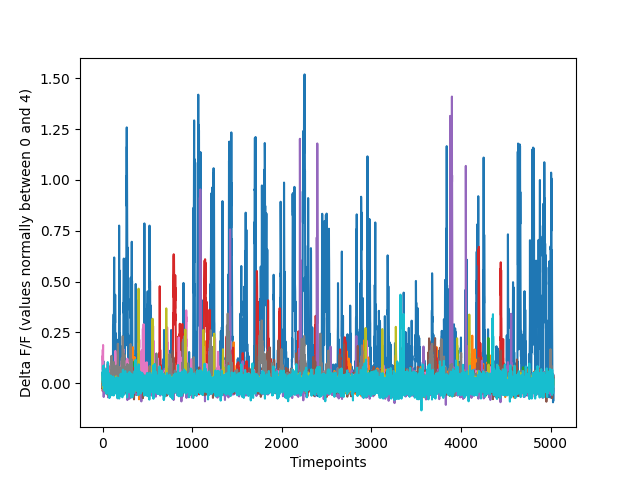

Text(0, 0.5, 'Delta F/F (values normally between 0 and 4)')

In [4]:
example_file = 'data/test_data.npy'       # enter your test file here
traces = load_neurons_x_time( example_file )

print('Number of neurons in dataset:', traces.shape[0])
print('Number of timepoints in dataset:', traces.shape[1])

random_neurons = np.random.randint(traces.shape[0], size=10)
plt.figure()
for neuron in random_neurons:
    plt.plot(traces[neuron,:])
    
plt.xlabel('Timepoints')
plt.ylabel('Delta F/F (values normally between 0 and 4)')

### Calculate noise level for one dataset

<IPython.core.display.Javascript object>


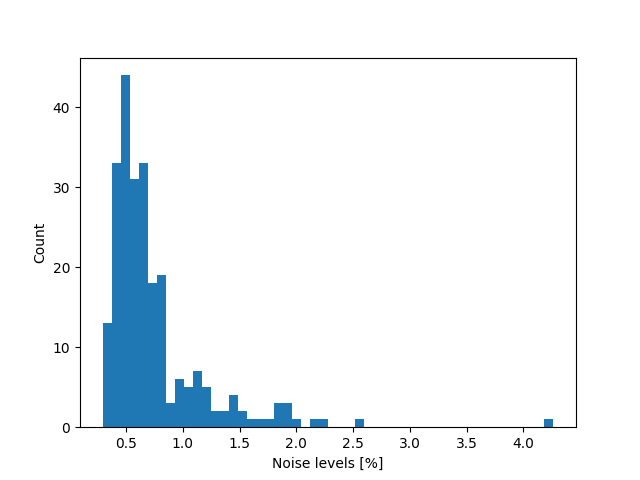

In [5]:
example_file = 'data/test_data.npy'  # enter your test file here
frame_rate = 15                      # Frame rate in Hz

dff_neurons_x_time = load_neurons_x_time( example_file )
noise_levels = utils.calculate_noise_levels(dff_neurons_x_time, frame_rate)

plt.figure()
plt.hist(noise_levels,bins=50)
plt.xlabel('Noise levels [%]')
_ = plt.ylabel('Count')

# Infer spike rates 

In [6]:
# Load model

model_folder = 'Pretrained_models/GCaMP6f_15Hz/'
all_models = glob.glob( os.path.join(model_folder, '*.h5') )
all_models = sorted( all_models )  # sort

# dictionary with key for noise level, entries are lists of models
model_dict = dict()

for model_path in all_models:
    try:
        noise_level = int( re.findall('_NoiseLevel_(\d+)', model_path)[0] )
        ensemble = int( re.findall('_Ensemble_(\d+)', model_path)[0] )
    except:
        print('Error while processing the file with name: ', model_path)
        raise
        
    if noise_level not in model_dict:
        model_dict[noise_level] = list()
    model_dict[noise_level].append(model_path)

In [7]:

file = 'data/test_data.npy'  # enter your test file here
frame_rate = 15

before_frac = 0.5   # TODO: load this from config file
window_size = 64    # TODO: load this from config file

keras_verbose = False   #  show indiviual fitting

dff_neurons_x_time = load_neurons_x_time(file)


noise_levels = utils.calculate_noise_levels(dff_neurons_x_time,
                                            frame_rate)

# XX has shape: (neurons, timepoints, windowsize)
XX = utils.preprocess_traces(dff_neurons_x_time,
                        before_frac = before_frac,
                        window_size = window_size)

Y_predict = np.zeros( (XX.shape[0], XX.shape[1]) )

noise_levels_model = np.arange(9)+1    # TODO: load from config


for i, model_noise in enumerate(noise_levels_model):

    print('Predictions noise level {}:'.format(model_noise))
    
    # select neurons which have this noise level:  # TODO make more general (e.g. argmin(abs(diff)))
    if i == 0:   # lowest noise
        neuron_idx = np.where( noise_levels < model_noise + 0.5 )[0]
    elif i == len(noise_levels_model)-1:   # highest noise
        neuron_idx = np.where( noise_levels > model_noise - 0.5 )[0]
    else:
        neuron_idx = np.where( (noise_levels > model_noise - 0.5) & (noise_levels < model_noise + 0.5) )[0]
    
    if len(neuron_idx) == 0:  # no neurons were selected
        print('\tNo neurons for this noise level')
        continue   # jump to next noise level
        
    # load keras models for the given noise level
    models = list()
    for model_path in model_dict[model_noise]:
        models.append( keras.models.load_model( model_path ) )

    # select neurons and merge neurons and timepoints into one dimension
    XX_sel = XX[neuron_idx, :, :]
    
    XX_sel = np.reshape( XX_sel, (XX_sel.shape[0]*XX_sel.shape[1], XX_sel.shape[2]) )
    XX_sel = np.expand_dims(XX_sel,axis=2)   # add empty third dimension to match training shape
    
    for j, model in enumerate(models):
        print('\t... ensemble', j)
        
        prediction_flat = model.predict(XX_sel, verbose=keras_verbose)
        prediction = np.reshape(prediction_flat, (len(neuron_idx),XX.shape[1]))
        
        Y_predict[neuron_idx,:] += prediction / len(models)  # average predictions
    
    # remove models from memory
    keras.backend.clear_session()
    
print('Done')

Predictions noise level 1:
	... ensemble 0
	... ensemble 1
	... ensemble 2
	... ensemble 3
	... ensemble 4
Predictions noise level 2:
	... ensemble 0
	... ensemble 1
	... ensemble 2
	... ensemble 3
	... ensemble 4
Predictions noise level 3:
	... ensemble 0
	... ensemble 1
	... ensemble 2
	... ensemble 3
	... ensemble 4
Predictions noise level 4:
	... ensemble 0
	... ensemble 1
	... ensemble 2
	... ensemble 3
	... ensemble 4
Predictions noise level 5:
Predictions noise level 6:
Predictions noise level 7:
Predictions noise level 8:
Predictions noise level 9:
Done


### Save results to data file (.npy or .mat)

In [8]:
folder = os.path.dirname(file)
save_path = os.path.join(folder, 'prediction_'+os.path.basename(file))

# save as numpy file
np.save(save_path, Y_predict)

# save as .mat file
# import scipy
# scipy.io.savemat(save_path, {'Y_predict': Y_predict})